In [1]:
import os
import copy
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
from torchvision.transforms import v2
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.animation as animation
import torch.optim as optim
from torch import nn
from PIL import Image

Класс-конфигурация для работы с данными. 

In [2]:
class datasetConfig:
    fixed_seq_len = 217 
    path = '/kaggle/input/data-col/data_colliding'
    solver = 'ros2'
    seed = 32

    device_pref = 'cuda'
    device = None

    batch_size = 32
    num_workers = 4
    loader_speed = False

In [3]:
torch.manual_seed(datasetConfig.seed)

In [4]:
def set_device(device_pref):
    device = None

    if device_pref == 'cuda' and torch.cuda.is_available():
        device = torch.device('cuda')
        print('Now using GPU.')
    else:
        device = torch.device('cpu')
        if device_pref == 'cuda':
            print('GPU not available, defaulting to CPU.')
        else:
            print('Now using CPU.')

    return device

# Подготовка данных


Данные хранятся в папке указанной в datasetConfig. Всего было сгенерировано 960 уникальных сценариев эволюции атмосферы (720 обучающих и 240 валидационных). Каждый сценарий содержит до
217 (для обучения бралось 215) временных шагов. 
На основе модели WxFactory (https://github.com/KirpichevIvan/WxFactory_random_bubbles) создан набор данных с тепловыми пузырями в двумерной атмосфере. Параметры генерации:
* Сетка 1000 × 1000 м
* 1-2 горячих (θ = 30.3 − 30.6◦C) и 0-2 холодных (θ = 29.8 − 29.95◦C) пузырей
* Гауссово распределение температуры: $\theta = \begin{cases} A, & r \leq a \\[8pt] A e^{-(r - a)^2 / s^2}, & r > a \end{cases}$
* Радиусы a = 10 − 80 м, координаты центров x0 = 200 − 800 м, z0 =
50 − 750 м

Таким образом рассматриваются файлы .npy в которых хранится информация о плотности, скорости ветра в 2х направлениях и температуре в 10000 точек. 

Численное решение будем использовать для обучения модели на основе сверточного автоэнкодера для аппроксимации оператора Купмана.

Применение оператора Купмана: 
Для нашей задачи будем рассматривать пространство состояний, которое задаётся как $M = L^2(\Omega, \mathbb{R}^4)$, где $\Omega \subset \mathbb{R}^2$. Состояние системы в момент времени $k$ представлено вектор-функцией:
$x_k(x^1, x^3) = \bigl(\rho_k(x^1, x^3),\,u_{k}^1(x^1, x^3),\,u_{k}^3(x^1, x^3),\,\theta_k(x^1, x^3)\bigr): \Omega \to \mathbb{R}^4, $
где компоненты $\rho_k$, $u_{k}^1$, $u_{k}^3$, $\theta_k$ - плотность, скорости ветра в двух направлениях и температура соответственно. 

Динамика системы определяется отображением $f\in C^{\infty}:M\to M$, $x_{k+1}=f(x_k)$, образуя дискретную динамическую систему $(M, f)$. 

Теперь рассмотрим пространство комплекснозначных функций на $M$: $F = \{g : M \to \mathbb{C}\},$
и зададим оператор Купмана $K : F \to F$ как:
$[K g](x_k) = g(f(x_k)).$
Таким образом, вместо того, чтобы смотреть на эволюцию самой точки состояния $x_k$ во времени, мы смотрим как меняется функция-наблюдаемая $g$ при переходе к новому состоянию $x_{k+1}$:
$[K g](x_k) = g(x_{k+1}).$

Реализация и обучение модели - в разделе Модель. Тут далее подготовим данные...

Функция get_num_instances сканирует файлы в указанной папке и возвращает множество уникальных идентификаторов экземпляров (эксперементов).

In [5]:
def get_num_instances(folder):
    inst = set()

    for filename in os.listdir(folder):
        parts = filename.split('_')

        base = parts[1].rsplit('.', 1)[0]  
        try:
            num = int(base.split('.')[0])
        except ValueError:
            continue

        inst.add(num)

    return inst

Функция get_training_lens определяет для каждого эксперемента длину последовательности (количество шагов). Стандартное количество шагов равно 215. При генерации некоторые временные шаги сталкивались с неустойчивостью, в таких случаях в набор не добавлялись последние 10 шагов.

In [6]:
def get_training_lens(folder, instances):
    inst_len_cache = {}

    for instance in instances:
        x = os.path.join(folder, f'{datasetConfig.solver}_{instance}.')

        for seq in range(0, datasetConfig.fixed_seq_len+1):
            x_seq = x + f'{seq}.npy'
            if not os.path.isfile(x_seq):
                if seq != datasetConfig.fixed_seq_len:
                    inst_len_cache[instance] = seq-10
                else:
                    inst_len_cache[instance] = seq-2
                break


    return inst_len_cache

Функция get_training_paths создаёт словарь, где каждому идентификатору файла сопоставляется полный путь к файлу данными. 

In [7]:
def get_training_paths(folder, instances, inst_len_cache):
    file_cache = {}

    for instance in instances:
        for seq in range(inst_len_cache[instance] + 1):
            x_file = f'{instance}.{seq}'
            file_cache[x_file] = os.path.join(folder, f'{datasetConfig.solver}_{x_file}.npy')
    return file_cache

In [8]:
instances = get_num_instances(datasetConfig.path)
seq_len_cache = get_training_lens(datasetConfig.path, instances)
file_cache = get_training_paths(datasetConfig.path, instances, seq_len_cache)

Вывод информации о данных (количество элементов и таблица с длинной каждого эксперемента).

In [9]:
def print_diagnostics(seq_len_cache, file_cache):
    print(f'Number of file: {len(file_cache)}')

    print('Inst | Seq. Len. \n================')
    for key, val in seq_len_cache.items():
        if val < 215:
            print(f'{key:4} | {val:3} <-- {val+10}')
        else:
            print(f'{key:4} | {val:3}')

In [10]:
print_diagnostics(seq_len_cache, file_cache)

Number of file: 202849
Inst | Seq. Len. 
   1 | 215
   2 | 215
   3 | 215
   4 | 215
   5 | 215
   6 | 215
   7 | 215
   8 | 215
   9 | 215
  10 | 215
  11 | 215
  12 | 215
  13 | 215
  14 | 215
  15 | 215
  16 | 215
  17 | 215
  18 | 215
  19 | 215
  20 | 215
  21 | 215
  22 | 215
  23 | 215
  24 | 215
  25 | 174 <-- 184
  26 | 215
  27 | 215
  28 | 215
  29 | 215
  30 | 215
  31 | 215
  32 | 215
  33 | 187 <-- 197
  34 | 215
  35 | 215
  36 | 176 <-- 186
  37 | 215
  38 | 215
  39 | 215
  40 | 215
  41 | 215
  42 | 215
  43 | 215
  44 | 215
  45 | 215
  46 | 180 <-- 190
  47 | 215
  48 | 215
  49 | 215
  50 | 215
  51 | 215
  52 | 215
  53 | 215
  54 | 215
  55 | 215
  56 | 215
  57 | 215
  58 | 153 <-- 163
  59 | 215
  60 | 175 <-- 185
  61 | 215
  62 | 215
  63 | 215
  64 | 215
  65 | 215
  66 | 215
  67 | 215
  68 | 215
  69 | 215
  70 | 185 <-- 195
  71 | 177 <-- 187
  72 | 215
  73 | 215
  74 | 215
  75 | 215
  76 | 148 <-- 158
  77 | 215
  78 | 190 <-- 200
  79 | 215
  80 | 215

In [11]:
datasetConfig.device = set_device(datasetConfig.device_pref)

Now using GPU.


Создаём набор пар файлов, где каждая пара состоит из двух последовательных временных шагов.

In [12]:
def setup_pairs(seq_len_cache, file_cache):
    pairs = []

    for instance, sequences in seq_len_cache.items():
        for seq in range(sequences+1):
            if seq == sequences:
                break

            pair = (file_cache[f'{instance}.{seq}'], file_cache[f'{instance}.{seq+1}'])
            pairs.append(pair)

    return np.array(pairs)

Разобьем данные на обучающую (720 эксперементов) и валидационную (240 эксперементов) выборки.

In [13]:
def train_test_split(seq_len_cache):
    train, test = {}, {}
    for key in seq_len_cache:
        if key < 241:
            test[key] = seq_len_cache[key]
        else:
            train[key] = seq_len_cache[key]

    return train, test

In [14]:
train_set, valid_set = train_test_split(seq_len_cache)
train_data, valid_data = setup_pairs(train_set, file_cache), setup_pairs(valid_set, file_cache)

Приведем данные которые состоят из массивов вида $(\rho, \rho u, \rho w, \rho \theta)$ к $(\rho, u, w, \theta)$ 

In [15]:
def get_indpendent_vars(x_vec):
    x_temp = copy.deepcopy(x_vec)

    x_density = x_temp[0]
    x_temp[1] = x_temp[1] / x_density
    x_temp[2] = x_temp[2] / x_density
    x_temp[3] = x_temp[3] / x_density

    return x_temp

In [16]:
print(f'Train size: {train_data.shape[0]}, Percent of toal: '
      f'{(train_data.shape[0] / (train_data.shape[0] + valid_data.shape[0])) * 100:.2f}%, '
      f'Unique instances: {len(train_set)}')
print(f'Valid size: {valid_data.shape[0]}, Percent of toal: '
      f'{(valid_data.shape[0] / (train_data.shape[0] + valid_data.shape[0])) * 100:.2f}%, '
      f'Unique instances: {len(valid_set)}')

Train size: 151545, Percent of toal: 75.06%, Unique instances: 720
Valid size: 50344, Percent of toal: 24.94%, Unique instances: 240


Визуализации пары входных и целевых данных. На верхней строке графиков отображаются нормализованные данные входного файла, а на нижней — нормализованные данные целевого файла для каждого из четырёх каналов (плотность, горизонтальная скорость, вертикальная скорость и температура).

In [25]:
def visual_pairs(data, index):
    fig, ax = plt.subplots(2, 4, figsize=(16, 6))
    fig.subplots_adjust(hspace=0.5)
    inp, tar = data[index]
    parts = tar.split('_')
    base = parts[2].rsplit('.', 1)[0]
    instance, time = base.split('.')

    inp_r, tar_r = np.load(inp), np.load(tar)
    inp_t, tar_t = inp_r.reshape(4, 100, 100), tar_r.reshape(4, 100, 100)
    inp_f, tar_f = get_indpendent_vars(inp_t), get_indpendent_vars(tar_t)

    fig.suptitle(f'Эксперимент: {instance}, Шаг: {time.split(".")[0]}, Абсолютная ошибка: {np.linalg.norm(inp_t-tar_t)}')

    variables = ['Плотность', 'Горизонтальная с.в.', 'Вертикальная с.в.', 'Температура']

    for i in range(4):
        im_inp = ax[0][i].imshow(inp_f[i], origin='lower')
        im_tar = ax[1][i].imshow(tar_f[i], origin='lower')

        fig.colorbar(im_inp, ax=ax[0][i], orientation='vertical', fraction=0.046, pad=0.04)
        fig.colorbar(im_tar, ax=ax[1][i], orientation='vertical', fraction=0.046, pad=0.04)

        ax[0][i].set_title(f'{variables[i]}: Наст. сост.')
        ax[1][i].set_title(f'{variables[i]}: Буд. сост.')
        ax[0][i].set_xlabel('x')
        ax[0][i].set_ylabel('y')
        ax[1][i].set_xlabel('x')
        ax[1][i].set_ylabel('y')

    plt.show()

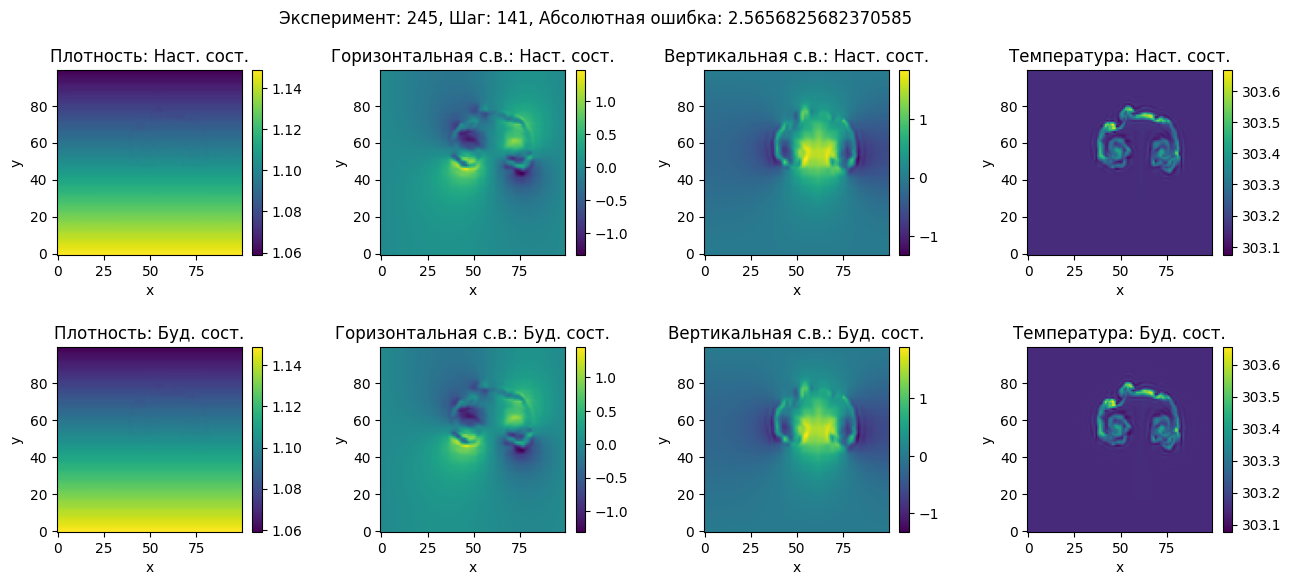

In [26]:
visual_pairs(train_data, 1000)

случайное горизонтальное отражение с вероятностью 0.5

In [27]:
aug_pipeline = v2.Compose([
    v2.RandomHorizontalFlip(0.5)
])

Нормализуем данные

In [28]:
def preprocess(input_tensor, target_tensor):
    std, mean = torch.std_mean(input_tensor, dim=(1, 2), keepdim=True)
    norm_input = (input_tensor - mean) / std
    norm_target = (target_tensor - mean) / std
    return norm_input, norm_target, mean, std

Предобработка и пакетная загрузка данных 

In [29]:
def load_instances(data_instance):
    inpt = torch.from_numpy(np.load(data_instance[0])).to(dtype=torch.float32)
    target = torch.from_numpy(np.load(data_instance[1])).to(dtype=torch.float32)
    return get_indpendent_vars(inpt.view(4, 100, 100)), get_indpendent_vars(target.view(4, 100, 100))

In [30]:
class collidingBubbles(Dataset):
    def __init__(self, data, device, loading_func, preprocess_func, data_aug=None):
        self.device = device
        self.data = data
        self.loading_func = loading_func
        self.preprocess_func = preprocess_func
        self.data_aug = data_aug

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        instance = self.data[idx]

        timestep = torch.tensor(int(instance[0].split('/')[-1].split('_')[-1].split('.')[1])).to(torch.float32)

        inpt, target = self.loading_func(instance)
        inpt, target, mean, std = self.preprocess_func(inpt, target)

        if self.data_aug is not None:
            inpt, target = self.data_aug(inpt), self.data_aug(target)

        return inpt, target, mean, std, timestep

In [31]:
train_dataset = collidingBubbles(train_data, datasetConfig.device, load_instances, preprocess, data_aug=aug_pipeline)
valid_dataset = collidingBubbles(valid_data, datasetConfig.device, load_instances, preprocess)

In [32]:
train_dl = DataLoader(train_dataset, batch_size=datasetConfig.batch_size, shuffle=True,
                      num_workers=datasetConfig.num_workers, drop_last=True, pin_memory=True)
valid_dl = DataLoader(valid_dataset, batch_size=datasetConfig.batch_size, shuffle=True,
                      num_workers=datasetConfig.num_workers, drop_last=True, pin_memory=True)

In [33]:
def timeit(dl):
    start_time = time.time()
    for batch in tqdm(train_dl):
        pass
    print(f'Time: {time.time() - start_time:.2f} seconds.')

In [34]:
if datasetConfig.loader_speed:
    timeit(dl)

In [35]:
inputs, targets, means, stds, timesteps = next(iter(train_dl))


In [36]:
print(f'Batch input size: "{inputs.size()}", Batch target size: "{targets.size()}"')


Batch input size: "torch.Size([32, 4, 100, 100])", Batch target size: "torch.Size([32, 4, 100, 100])"


Визуализация батча 

In [41]:
def visualize_batch(batch, mean, std):
    cols = int(np.sqrt(datasetConfig.batch_size))
    rows = int(np.ceil(datasetConfig.batch_size / cols))

    fig, ax = plt.subplots(rows, cols, figsize=(20, 20))

    for i in range(datasetConfig.batch_size):
        row = i // cols
        col = i % cols
        inst_t = (batch[i] * std[i]) + mean[i]
        ax[row][col].imshow(inst_t[3], origin='lower')
        ax[row][col].set_xticks([])
        ax[row][col].set_yticks([])
        
    for j in range(datasetConfig.batch_size, rows * cols):
        fig.delaxes(ax.flatten()[j])

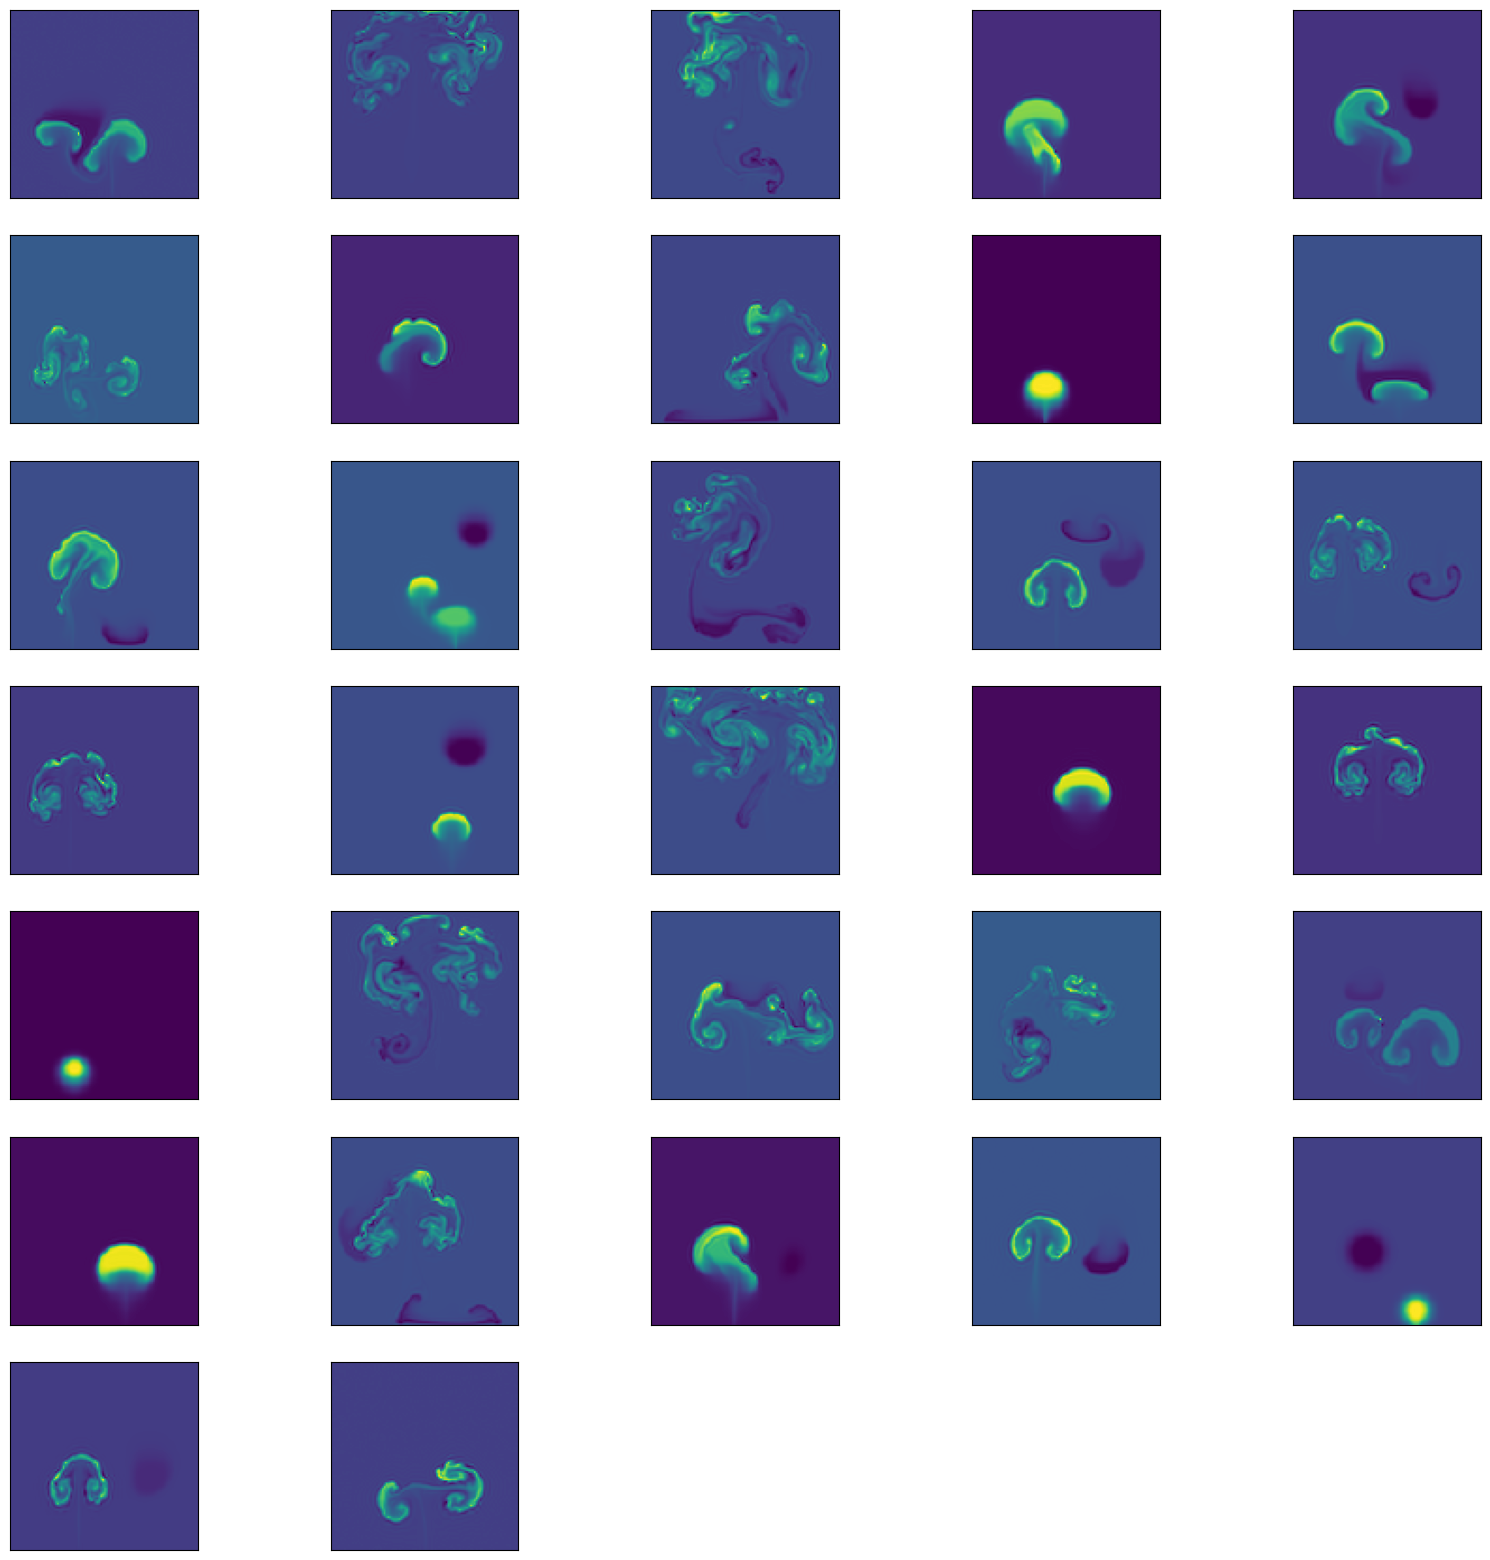

In [42]:
visualize_batch(inputs, means, stds)


# Модель

загружаем сохранённое состояние весов модели из файла и обновляем текущие параметры модели

In [43]:
def load_model_weights(model, state_dict_path):
    state_dict = torch.load(state_dict_path)
    current_state_dict = model.state_dict()
    current_state_dict.update(state_dict)
    model.load_state_dict(current_state_dict, strict=False)
    return model

гиперпараметры и настройки, связанные с архитектурой модели

In [44]:
class ModelConfig:
    input_size = 100
    input_channels = 1
    output_size = 100
    output_channels = 1

    down_n = 4
    up_n = 4
    conv_blocks = 2

    latent_size = 1000
    epochs = 50
    patience = 3

    model = True
    model_pretrain_load = True
    model_additional_training = False

визуализации результатов работы модели

In [45]:
def visual_pred(rec, inpt, pred, tar, other, mean, std, filename):
    fig, ax = plt.subplots(2, 2, figsize=(12, 10))

    rec = (rec * std[3]) + mean[3]
    inpt = (inpt * std[3]) + mean[3]
    pred = (pred * std[3]) + mean[3]
    tar = (tar * std[3]) + mean[3]

    fig.suptitle(f'Ошибка реконструкции: {np.linalg.norm(rec-inpt)}, Ошибка предсказания: {np.linalg.norm(pred-tar)}')

    variables = 'Температура'

    im_rec = ax[0][0].imshow(rec[0], origin='lower')
    im_inpt = ax[0][1].imshow(inpt[0], origin='lower')

    im_pred = ax[1][0].imshow(pred[0], origin='lower')
    im_tar = ax[1][1].imshow(tar[0], origin='lower')

    fig.colorbar(im_rec, ax=ax[0][0], orientation='vertical', fraction=0.046, pad=0.04)
    fig.colorbar(im_inpt, ax=ax[0][1], orientation='vertical', fraction=0.046, pad=0.04)

    fig.colorbar(im_pred, ax=ax[1][0], orientation='vertical', fraction=0.046, pad=0.04)
    fig.colorbar(im_tar, ax=ax[1][1], orientation='vertical', fraction=0.046, pad=0.04)

    ax[0][0].set_title(f'{variables}: Реконструкция')
    ax[0][1].set_title(f'{variables}: Настоящее состояние')
    ax[0][0].set_xlabel('x')
    ax[0][0].set_ylabel('y')
    ax[0][1].set_xlabel('x')
    ax[0][1].set_ylabel('y')

    ax[1][0].set_title(f'{variables}: Предсказание')
    ax[1][1].set_title(f'{variables}: Будущее состояние')
    ax[1][0].set_xlabel('x')
    ax[1][0].set_ylabel('y')
    ax[1][1].set_xlabel('x')
    ax[1][1].set_ylabel('y')

    plt.savefig(f'{filename}.png')
    plt.show()

In [46]:
def inspect_validation_modified(inputs, targets, other, model, means, stds, ind, filename):
    inputs = inputs[:, 3, :, :].unsqueeze(1).to(datasetConfig.device)
    targets = targets[:, 3, :, :].unsqueeze(1).to(datasetConfig.device)

    model.eval()
    with torch.no_grad():
        decoder_rec, decoder_pred, _, _, _ = model(inputs, targets)

    visual_pred(decoder_rec[ind].cpu(), inputs[ind].cpu(), decoder_pred[ind].cpu(), targets[ind].cpu(), other[ind], means[ind], stds[ind], filename)

Количество параметров в модели

In [47]:
def get_params(model):
    params = 0

    for param in model.parameters():
        l = list(param.shape)
        params += int(torch.prod(torch.tensor(l)))

    return params

Класс ResidualBlock реализует остаточный блок 

In [48]:
class ResidualBlock(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size, stride, padding):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(input_dim, output_dim, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.GroupNorm(8, output_dim),
            nn.ReLU(),
            nn.Dropout2d(0.1),
            nn.Conv2d(output_dim, output_dim, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.GroupNorm(8, output_dim)
        )
        self.relu = nn.ReLU()
        self.drop = nn.Dropout2d(0.1)

        self.change_dims = True if input_dim != output_dim else False
        self.change_dim_block = nn.Sequential(
            nn.Conv2d(input_dim, output_dim, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.GroupNorm(8, output_dim)
        )

    def forward(self, inpt):
        out_block = self.block(inpt)

        out = None
        if self.change_dims:
            out = self.change_dim_block(inpt) + out_block
        else:
            out = inpt + out_block

        out = self.relu(out)
        out = self.drop(out)
        return out

реализуем модуль для понижающей свёртки в рамках энкодерной части сети, последовательно применяем несколько остаточных блоков, а затем операцию max pooling для уменьшения пространственного разрешения.

In [49]:
class DownConv(nn.Module):
    def __init__(self, input_dim, filter_dim, kernals, strides, paddings):
        super().__init__()
        self.layers = []
        self.pool = nn.MaxPool2d(2)

        self.layers.append(ResidualBlock(input_dim, filter_dim, kernals[0], strides[0], paddings[0]))

        for ind in range(1, len(kernals)):
            self.layers.append(ResidualBlock(filter_dim, filter_dim, kernals[ind], strides[ind], paddings[ind]))

        self.layers.append(self.pool)

        self.full_block = nn.Sequential(*self.layers)

    def forward(self, inpt):
        return self.full_block(inpt)

реализуем модуль для увеличения пространственного разрешения в рамках декодирующей части сети, аналогично понижающему модулю состоит из остаточных блоков с последующим слоем транспонированной свёртки для увеличения размеров карты признаков

In [50]:
class UpConv(nn.Module):
    def __init__(self, filter_dim, output_dim, kernals, strides, paddings, output_padding=0):
        super().__init__()
        self.layers = []

        self.layers.append(ResidualBlock(filter_dim, filter_dim, kernals[0], strides[0], paddings[0]))

        for ind in range(1, len(kernals)):
            self.layers.append(ResidualBlock(filter_dim, filter_dim, kernals[ind], strides[ind], paddings[ind]))

        self.layers.append(nn.ConvTranspose2d(filter_dim, output_dim, 2, 2, 0, output_padding=output_padding))
        self.layers.append(nn.BatchNorm2d(output_dim))

        self.full_block = nn.Sequential(*self.layers)

    def forward(self, inpt):
        return self.full_block(inpt)

реализуем энкодерную часть нейронной сети, которая последовательно сворачивает входные данные, уменьшая их пространственное разрешение и увеличивая число каналов

In [51]:
class Encoder(nn.Module):
    def __init__(self, input_dim, down_n, init_filters, conv_blocks):
        super().__init__()
        self.layers = []
        self.prev_filters = input_dim
        self.next_filters = init_filters

        self.kern = [3 for _ in range(conv_blocks)]
        self.stride = [1 for _ in range(conv_blocks)]
        self.pad = [1 for _ in range(conv_blocks)]

        self.layers.append(DownConv(self.prev_filters, self.next_filters, self.kern, self.stride, self.pad))
        self.prev_filters = self.next_filters
        self.next_filters *= 2

        for down_ind in range(1, down_n):
            self.layers.append(DownConv(self.prev_filters, self.next_filters, self.kern, self.stride, self.pad))
            self.prev_filters = self.next_filters
            self.next_filters *= 2

        self.full_block = nn.Sequential(*self.layers)

    def forward(self, inpt):
        return self.full_block(inpt)

аналогично энкодеру реализуем декодирующую часть нейронной сети, которая восстанавливает пространственное разрешение признаков

In [52]:
class Decoder(nn.Module):
    def __init__(self, output_dim, up_n, init_filters, conv_blocks):
        super().__init__()
        self.layers = []
        self.prev_filters = init_filters
        self.next_filters = int(init_filters / 2)
        self.output_dim = output_dim

        self.kern = [3 for _ in range(conv_blocks)]
        self.stride = [1 for _ in range(conv_blocks)]
        self.pad = [1 for _ in range(conv_blocks)]

        for up_ind in range(0, up_n-1):
            if up_n - up_ind == 3:
                self.layers.append(UpConv(self.prev_filters, self.next_filters, self.kern, self.stride, self.pad, output_padding=1))
            else:
                self.layers.append(UpConv(self.prev_filters, self.next_filters, self.kern, self.stride, self.pad))
            self.prev_filters = self.next_filters
            self.next_filters = int(self.next_filters / 2)

        self.layers.append(UpConv(self.prev_filters, self.output_dim, self.kern, self.stride, self.pad))

        self.full_block = nn.Sequential(*self.layers)

    def forward(self, inpt):
        return self.full_block(inpt)

Модель TempModel использует энкодер для сжатия входного изображения в латентное пространство, где с помощью линейных слоёв (latent1 и latent2) происходит преобразование представлений. Одновременно на выходе из latent1 применяется линейный оператор Купмана (kooplatent), который моделирует эволюцию системы в латентном пространстве. Декодер затем восстанавливает изображение для двух сценариев:
* реконструкция: фактическое восстановление исходного входного состояния.
* предсказание: вывод предсказанного следующего состояния на основе латентного представления, эволюционированного с помощью оператора Купмана.

In [53]:
    class TempModel(nn.Module):
        def __init__(self):
            super().__init__()
    
            self.encoder = Encoder(1, 4, 64, 2)
            self.decoder = Decoder(1, 4, 512, 2)
    
            self.latent1 = nn.Linear(18432, 4096)
            self.latent2 = nn.Linear(4096, 18432)
            self.relu = nn.ReLU()
            self.flatten = nn.Flatten()
    
            self.ind_drop = nn.Dropout(p=0.18)   
    
            self.kooplatent = nn.Linear(4096, 4096, bias=False)
    
        def forward(self, inpt, tar):
            encoder_out = self.relu(self.flatten(self.encoder(inpt)))
            latent_down = self.latent1(encoder_out)
    
            latent_down  = self.ind_drop(latent_down)
    
            latent_up = self.latent2(latent_down)
            latent_up_nonl = self.relu(latent_up)
            decoder_out = self.decoder(latent_up_nonl.view(32, 512, 6, 6))
    
            koopman_out = self.kooplatent(latent_down)
    
            encoder_pred_out = self.relu(self.flatten(self.encoder(tar)))
            latent_pred_down = self.latent1(encoder_pred_out)
    
            latent_up_pred = self.latent2(koopman_out)
            latent_up_pred_nonl = self.relu(latent_up_pred)
            decoder_pred = self.decoder(latent_up_pred_nonl.view(32, 512, 6, 6))
    
            pred_out = self.relu(self.flatten(self.encoder(decoder_pred)))
            addional_constraint = self.latent1(pred_out)
    
            return decoder_out, decoder_pred, koopman_out, latent_pred_down, addional_constraint

In [54]:
temp_model = TempModel().to(datasetConfig.device)

In [55]:
inputs, targets, means, stds, _ = next(iter(valid_dl))

визуализируем работу модели

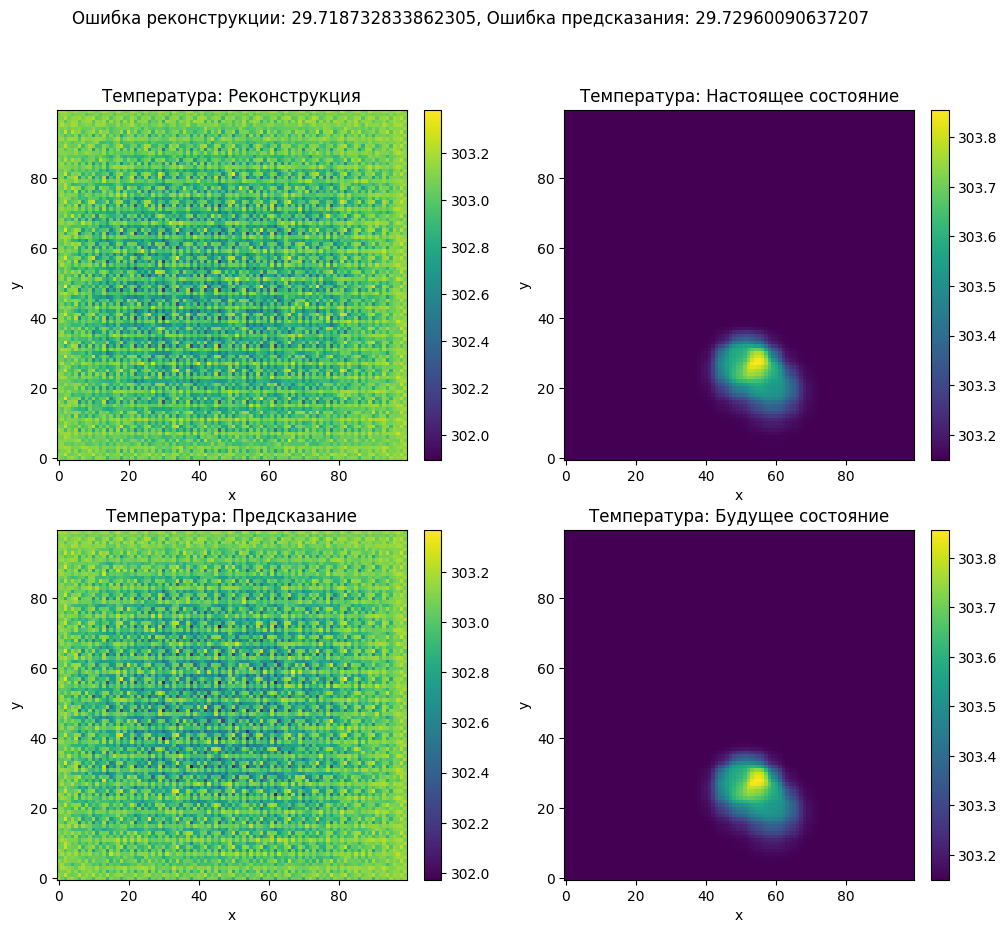

In [56]:
inspect_validation_modified(inputs, targets, inputs, temp_model, means, stds, 0, 'test')

In [57]:
print(f'Learnable parameters Temp: {get_params(temp_model)}')


Learnable parameters Temp: 202951107


step_temp запускает прямой проход через модель и вычисляет значение ошибки с использованием заданной функции потерь

In [58]:
def step_temp(batch, model, criterion):
    inputs, targets, _, _, _ = batch
    inputs = inputs[:, 3, :, :].unsqueeze(1).to(datasetConfig.device)
    targets = targets[:, 3, :, :].unsqueeze(1).to(datasetConfig.device)

    decoder_rec, decoder_pred, y_k_0, y_k_1, add = model(inputs, targets)
    loss = criterion(inputs, targets, decoder_rec, decoder_pred, y_k_0, y_k_1, add)
    return loss

In [59]:
def check_point(val_loss, best_val_loss, model, patience_counter):
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), save_path)
        print("model was saved")
    else:
        patience_counter += 1

    return patience_counter, best_val_loss

Функция потерь KoopmanLoss

\begin{equation}
\begin{split}
\mathcal{L} = &\underbrace{\| x_k - g^{-1}(g(x_k)) \|_{\text{MSE}}}_{\text{восстановление}} 
+ \underbrace{\| x_{k+1} - g^{-1}(K_m g(x_k)) \|_{\text{MSE}}}_{\text{предсказание}} \\
&+ \underbrace{\| g(x_{k+1}) - K_m g(x_k) \|_{\text{MSE}}}_{\text{линейность}} 
+ \underbrace{\| g(\tilde{x}_{k+1}) - K_m g(x_k) \|_{\text{MSE}}}_{\text{шум}} \\
&+ \underbrace{\| g(\tilde{x}_{k+1}) - g(x_{k+1}) \|_{\text{MSE}}}_{\text{замена}}
\end{split}
\end{equation}

In [60]:
class KoopmanLoss(nn.Module):
    def __init__(self, a1, a2, a3, a4):
        super().__init__()
        self.mse = nn.MSELoss()
        self.a1 = a1
        self.a2 = a2
        self.a3 = a3
        self.a4 = a4

    def forward(self, inpt, target, decoder_rec, decoder_pred, y_k_0, y_k_1, additional_constraint):
        reconstruction = self.mse(inpt, decoder_rec)
        prediction = self.mse(target, decoder_pred)
        linearity = self.mse(y_k_0, y_k_1)
        similar_koop1 = self.mse(additional_constraint, y_k_0)
        similar_koop2 = self.mse(additional_constraint, y_k_1)

        return (self.a1 * reconstruction) + (self.a2 * prediction) + (self.a3 * linearity) + (self.a4 * similar_koop1) + (self.a4 * similar_koop2)

In [61]:
for param in temp_model.encoder.parameters():
    param.requires_grad = True

for param in temp_model.decoder.parameters():
    param.requires_grad = True

In [62]:
import torch
torch.cuda.empty_cache()

реализуем цикл обучения с использованием оптимизатора Adam

In [63]:
def train(train, valid, model, epochs, patience, criterion, lr, save_path, loading_bar=True):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):

        model.train()
        train_loss = 0
        if loading_bar:
            loader = tqdm(train, desc=f'Training', leave=False, mininterval=2.0)
        else:
            loader = train

        for train_batch in loader:
            loss = step_temp(train_batch, model, criterion)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            if loading_bar:
                loader.set_postfix(train_loss=loss.item())

        train_loss /= len(train)

        model.eval()
        val_loss = 0
        if loading_bar:
            loader = tqdm(valid, desc=f'Validation', leave=False, mininterval=2.0)
        else:
            loader = valid

        with torch.no_grad():
            for valid_batch in loader:
                loss = step_temp(valid_batch, model, criterion)

                val_loss += loss.item()

                if loading_bar:
                    loader.set_postfix(val_loss=loss.item())

        val_loss /= len(valid)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}')

        patience_counter, best_val_loss = check_point(val_loss, best_val_loss, model, patience_counter)

        if patience_counter >= patience:
            print('Early stopping triggered')
            break

In [64]:
print(next(temp_model.parameters()).device)

cuda:0


In [65]:
if ModelConfig.model:
    pretrain_path = '/kaggle/input/model81/model_81ep.pth'
    temp_model = load_model_weights(temp_model, pretrain_path)

    criterion = KoopmanLoss(1, 1, 1, 1)
    learning_rate = 1e-06
    save_path = 'new_model.pth'
    train(train_dl, valid_dl, temp_model, 1, ModelConfig.patience, criterion, learning_rate, save_path)

/tmp/ipykernel_31/4110470531.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(state_dict_path)


Training:   0%|          | 0/4735 [00:00<?, ?it/s]

Validation:   0%|          | 0/1573 [00:00<?, ?it/s]

Epoch 1/1, Train Loss: 0.3814971461781982, Validation Loss: 0.39764361891561606
model was saved


In [66]:
inputs, targets, means, stds, _ = next(iter(valid_dl))

визуализация работы модели (реконструкция и предсказание 1 шага)

tensor(0.0837)


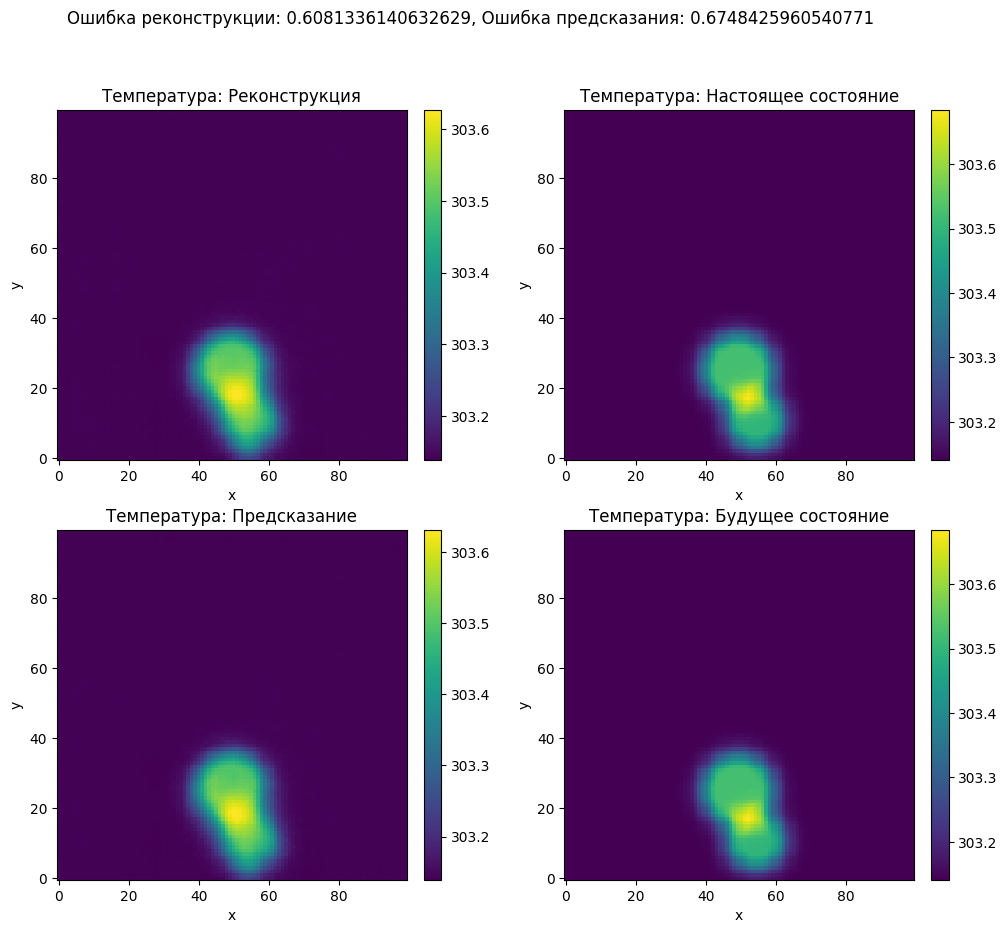

In [75]:
if ModelConfig.model:
    print(torch.linalg.norm(inputs[0][3] - targets[0][3]))
    inspect_validation_modified(inputs, targets, inputs, temp_model, means, stds, 1, 'visualization_of_the_models_work')

проверим работу модели для предсказания нескольких шагов

In [68]:
pred, ground = [], []

In [69]:
for i in range(0, valid_set[1]):
    inpt, target, mean, std = preprocess(*load_instances(valid_data[i]))
    ground.append(inpt[3])

In [70]:
inputs, targets, _, _ = preprocess(*load_instances(valid_data[0]))
inputs, targets = inputs.repeat(32, 1, 1, 1), targets.repeat(32, 1, 1, 1)

pred.append(inputs[0][3].unsqueeze(0))

In [71]:
if True:
    temp_model.eval()
    with torch.no_grad():
        decoder_rec, decoder_pred, _, _, _ = temp_model(inputs[:, 3, :, :].unsqueeze(1).to(datasetConfig.device), targets[:, 3, :, :].unsqueeze(1).to(datasetConfig.device))
        pred.append(decoder_pred[0, :, :, :])

        for _ in range(valid_set[1]-2):
            _, decoder_pred, _, _, _ = temp_model(decoder_pred, decoder_pred)
            pred.append(decoder_pred[0, :, :, :])

In [73]:
import math

def save_grid(imgs, fname, vmin, vmax, cmap="viridis"):
    n = len(imgs)
    ncols = math.ceil(math.sqrt(n))
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(nrows, ncols,
                             figsize=(ncols*1.8, nrows*1.8),
                             constrained_layout=True)
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    for idx, ax in enumerate(axes):
        ax.axis("off")
        if idx < n:
            img = imgs[idx]
            if img.ndim == 3:          
                img = img[0]
            ax.imshow(img.cpu(), origin="lower", cmap=cmap,
                      vmin=vmin, vmax=vmax)

    plt.savefig(fname, dpi=200, bbox_inches="tight")
    plt.close(fig)


In [74]:
first_img = ground[0]             
vmin, vmax = float(first_img.min()), float(first_img.max())

save_grid(pred,   "pred_grid_v2.png",   vmin=vmin, vmax=vmax)   
save_grid(ground, "ground_grid_v2.png",   vmin=vmin, vmax=vmax)  

In [68]:
# def pred_image_animation(imgs):
#     fig, ax = plt.subplots()
#     ax.axis('off')
    
#     frame_display = ax.imshow(imgs[0][0].cpu(), origin='lower', interpolation='none')

#     def update_frame(frame_number):
#         frame_display.set_array(imgs[frame_number][0].cpu())
#         return [frame_display]

#     ani = animation.FuncAnimation(fig, update_frame, frames=len(imgs), interval=1, blit=True)
    
#     output_path = f'pred81_10.gif'
#     ani.save(output_path, writer='Pillow', fps=20)
    
# def ground_image_animation(imgs):
#     fig, ax = plt.subplots()
#     ax.axis('off')
    
#     frame_display = ax.imshow(imgs[0].cpu(), origin='lower', interpolation='none')

#     def update_frame(frame_number):
#         frame_display.set_array(imgs[frame_number].cpu())
#         return [frame_display]

#     ani = animation.FuncAnimation(fig, update_frame, frames=len(imgs), interval=1, blit=True)
    
#     output_path = f'ground81_10.gif'
#     ani.save(output_path, writer='Pillow', fps=20)

In [69]:
# pred_image_animation(pred)
# ground_image_animation(ground)